In [315]:
'''--------------------------------------------'''

label = 'log_MIC1'

features = ['AAC']

# Table 정보
learning_db_name    = 'eq_mid_90_if'
learning_table      = 'eq_mid'

test_db_name        = 'lg_mid_90_if'
test_table          = 'lg_mid'

near_bound = 1
split_rate = 7

graph_max = 10

'''--------------------------------------------'''
'''
[ * ] amp : eq_mid, eq_long, eq_short, ls_mid, ls_long, ls_short, lg_mid, lg_long, lg_short (clusted 90%)
amp : eq_mid_or, eq_long_or, eq_short_or, ls_mid_or, ls_long_or, ls_short_or, lg_mid_or, lg_long_or, lg_short_or (original)

features = ['AAC', 'CTD_C', 'CTD_D', 'CTD_T', 'CTriad', 'DDE', 'DPC', 'GAAC', 'GDPC', 'GTPC']

'''

# feature selection

import pymysql
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# 데이터베이스 설정 정보
host = '127.0.0.1'
user = 'root'
password = ''
charset = 'utf8mb4'


In [316]:
# check # of rows in feature table

def get_table_row_count(host, user, password, db, table_name):
    # 데이터베이스 연결
    conn = pymysql.connect(host=host, user=user, password=password, db=db, charset=charset)
    
    cursor = conn.cursor()

    try:
        # 테이블의 행 수를 조회하는 SQL 쿼리 실행
        cursor.execute(f"SELECT COUNT(*) FROM `{table_name}`")
        row_count = cursor.fetchone()[0]  # 첫 번째 결과값의 첫 번째 필드 가져오기
        print(f"The table '{table_name}' has {row_count} rows.")
        return row_count
    except pymysql.Error as e:
        print(f"Error: {e}")
    finally:
        cursor.close()
        conn.close()
        
# 학습 데이터베이스의 테이블별 행 수 출력
print(f"Rows in the '{learning_table}' table from the '{learning_db_name}' database:")
get_table_row_count(host, user, password, learning_db_name, learning_table)
for table in features:
    get_table_row_count(host, user, password, learning_db_name, table)

# 테스트 데이터베이스의 테이블 행 수 출력
print(f"\nRows in the '{test_table}' table from the '{test_db_name}' database:")
get_table_row_count(host, user, password, test_db_name, test_table)
for table in features:
    get_table_row_count(host, user, password, test_db_name, table)


Rows in the 'eq_mid' table from the 'eq_mid_90_if' database:
The table 'eq_mid' has 5299 rows.
The table 'AAC' has 5299 rows.

Rows in the 'lg_mid' table from the 'lg_mid_90_if' database:
The table 'lg_mid' has 1241 rows.
The table 'AAC' has 1241 rows.


In [317]:
# model : learning

from sklearn.metrics import mean_absolute_error, r2_score

# 컬럼 이름을 가져오는 함수
def get_column_names(conn, table_name):
    cursor = conn.cursor()
    cursor.execute(f"SHOW COLUMNS FROM {learning_db_name}.{table_name}")
    columns = [col[0] for col in cursor.fetchall() if col[0] != 'Seq']
    cursor.close()
    return columns

def load_data_from_db():
    try:
        # 데이터베이스 연결 설정
        conn = pymysql.connect(host=host, user=user, password=password, db=learning_db_name, charset=charset)

        # 각 테이블에서 컬럼 이름을 가져와 SQL 쿼리 구성 요소를 생성합니다.
        all_columns = []
        joins = []
        for feature in features:
            # 컬럼 이름 가져오기
            columns = get_column_names(conn, f'{feature}')
            
            # 첫 번째 테이블의 'Seq' 컬럼 추가
            if feature == features[0]:
                all_columns.append(f'{feature}.`Seq`')
            
            # 컬럼명에 테이블 이름을 접두사로 붙여 구별
            all_columns.extend([f'{feature}.`{col}` AS `{feature}_{col}`' for col in columns])
            
            # 첫 번째 테이블을 제외하고 JOIN 구문을 생성
            if feature != features[0]:
                joins.append(f'JOIN {learning_db_name}.{feature} ON {features[0]}.Seq = {feature}.Seq')

        # SQL 쿼리를 생성합니다.
        sql_query = f"SELECT {', '.join(all_columns)} FROM {learning_db_name}.{features[0]} " + " ".join(joins)
        
        # 동적으로 생성된 SQL 쿼리로 데이터를 불러옵니다.
        data = pd.read_sql_query(sql_query, conn)

        # 라벨 불러오기
        cursor = conn.cursor()
        sql_mic = f"SELECT {label} FROM {learning_db_name}.{learning_table};"
        cursor.execute(sql_mic)
        result = cursor.fetchall()
        mic_values = [row[0] for row in result]
        data['Label'] = mic_values

        # 데이터베이스 연결 종료
        conn.close()

        return data
    
    except Exception as e:
        print(f"An error occurred: {e}")
        # 예외 발생 시, 데이터베이스 연결이 있으면 종료
        if 'conn' in locals():
            conn.close()
        return pd.DataFrame()


def train_and_evaluate(data):
    try:
        # MIC 라벨과 특징 분리
        labels = data['Label']
        features = data.drop(['Label', 'Seq'], axis=1)  # 'Seq'와 'Label' 컬럼 제거
        
        # k-fold 설정
        kf = KFold(n_splits=split_rate, shuffle=True, random_state=42)
        
        # RMSE 점수를 저장할 리스트
        rmse_scores = []
        mse_scores = []
        
        best_rmse = float("inf")
        best_model = None

        # k-fold 교차 검증 시작
        for train_index, test_index in kf.split(features):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
            
            # 모델 생성 및 훈련
            model = xgb.XGBRegressor()
            model.fit(X_train, y_train)
            
            # 예측 및 평가
            predictions = model.predict(X_test)
            
            rmse = mean_squared_error(y_test, predictions, squared=False)
            rmse_scores.append(rmse)
            
            mse = mean_squared_error(y_test, predictions)  # MSE 계산
            mse_scores.append(mse)  # MSE 점수를 리스트에 추가
            
            # 모델 저장 조건 검사 (예: RMSE 기준)
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model

        # 평균 RMSE 출력
        print(f"Average RMSE: {np.mean(rmse_scores):.2f} +/- {np.std(rmse_scores):.2f}")
        
        # 평균 MSE 출력
        print(f"Average MSE: {np.mean(mse_scores):.2f} +/- {np.std(mse_scores):.2f}")
        
        # MAE 계산
        mae = mean_absolute_error(y_test, predictions)
        print(f"MAE: {mae}")

        # R² 계산
        r2 = r2_score(y_test, predictions)
        print(f"R²: {r2}")

        
        if best_model is not None:
            # 가장 성능이 좋았던 모델을 JSON 형식으로 저장
            best_model.get_booster().save_model('xgb_model.json')            
            return best_model  # 모델 반환
        else:
            print("No model was trained.")
            return None
    except Exception as e:
        print(f"An error occurred during model training: {e}")


if __name__ == "__main__":
    data = load_data_from_db()
    if not data.empty:
        model = train_and_evaluate(data)
    else:
        print("Data loading failed. Training was not started.")


/var/folders/vd/gb2wz7l94dz2v6ncdb6p042r0000gn/T/ipykernel_51998/1717970665.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(sql_query, conn)


Average RMSE: 1.29 +/- 0.04
Average MSE: 1.65 +/- 0.11
MAE: 0.9537388432843255
R²: 0.32295371983587695


/var/folders/vd/gb2wz7l94dz2v6ncdb6p042r0000gn/T/ipykernel_51998/3337266887.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(sql_query, conn)


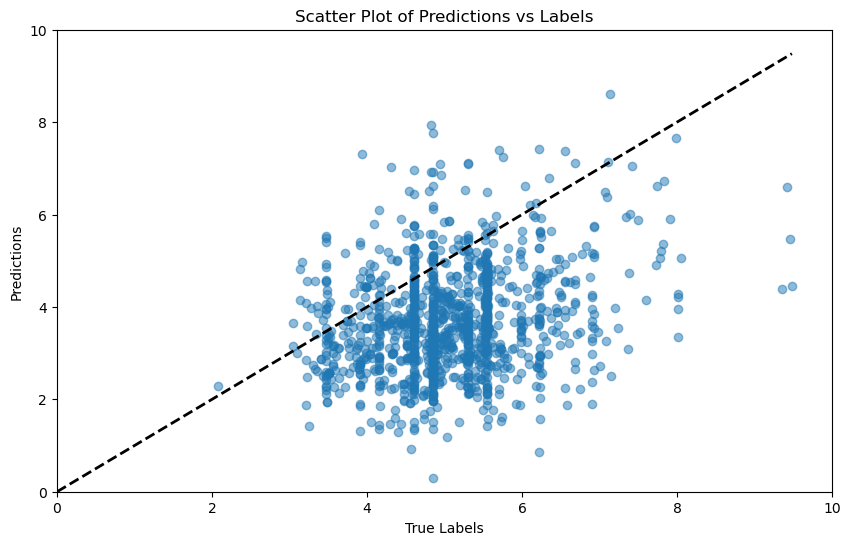

                            Seq     Label  Predicted
1     KKAAAVAAAAAVAAWAAVAAAKKKK  4.314527   4.388703
3                 GLFDIIKKIAESI  4.605170   5.740955
16               EPILGIITSLLKSL  4.605170   4.835340
37         ILGPVISTIGNALGGLLKNL  4.605170   5.267605
41                FAPLIGRVLSGIL  3.993173   4.441932
...                         ...       ...        ...
1212               DILIIVGGRRRR  4.512149   5.234066
1218               REVLGYERNSYK  5.266556   6.540782
1220              SHHRCCRSHRCRR  3.465736   3.856993
1222                 NHHRRHHRCR  3.465736   3.956635
1236    GAHKEVFKRDTALTKEAAKKAKK  4.852030   6.921503

[159 rows x 3 columns]
lg_mid
Total cases: 1241
Number of accurate predictions: 159
Accuracy rate: 12.81%
Number of near accurate predictions: 302
Near accuracy rate: 37.15%


In [318]:
# testing

csv_save_dir = '/Users/kimsohui/Project/bioinformatics/Data/SH/prediction_result'  # 실제 경로로 대체해야 합니다.

# 컬럼 이름을 가져오는 함수
def get_column_names(conn, table_name):
    cursor = conn.cursor()
    query = f"SHOW COLUMNS FROM {test_db_name}.{table_name}"
    cursor.execute(query)
    columns = [col[0] for col in cursor.fetchall() if col[0] != 'Seq']
    cursor.close()
    return columns


def load_testdata_from_db():
    try:
        # 데이터베이스 연결 설정
        conn = pymysql.connect(host=host, user=user, password=password, db=test_db_name, charset=charset)
                
        # 각 테이블에서 컬럼 이름을 가져옵니다.
        columns_dict = {}
        for feature in features:
            columns_dict[feature] = get_column_names(conn, feature)
        
        # 중복되지 않는 Seq를 포함하여 전체 컬럼 리스트를 생성합니다.
        all_columns = [f"{features[0]}.`Seq`"] + \
                      [f"{feat}.`{col}` AS `{feat}_{col}`" for feat in features for col in columns_dict[feat]]
        
        # SQL 쿼리를 생성합니다.
        joins = " ".join([f"JOIN {test_db_name}.{feat} ON {features[0]}.Seq = {feat}.Seq" for feat in features[1:]])
        sql_query = f"SELECT {', '.join(all_columns)} FROM {test_db_name}.{features[0]} {joins}"
        
        
        # 동적으로 생성된 SQL 쿼리로 데이터를 불러옵니다.
        data = pd.read_sql_query(sql_query, conn)
        
        # 데이터베이스 연결 종료
        conn.close()
        
        return data
        
    
    except Exception as e:
        print(f"An error occurred: {e}")
        # 예외 발생 시, 데이터베이스 연결이 있으면 종료
        if 'conn' in locals():
            conn.close()
        return pd.DataFrame()
    
    
def predict_and_evaluate(model):
    # 테스트 데이터 로드
    test_data = load_testdata_from_db()  # Fetch test data from database
    
    # 데이터베이스 연결 설정
    conn = pymysql.connect(host=host, user=user, password=password, db=test_db_name, charset=charset)

    # 라벨 불러오기
    cursor = conn.cursor()
    sql_mic = f"SELECT {label} FROM {test_db_name}.{test_table};"
    cursor.execute(sql_mic)
    result = cursor.fetchall()
    conn.close()  # 데이터베이스 연결 종료
    
    # result에서 label 값을 추출
    test_labels = np.array([row[0] for row in result])
    test_data['Label'] = test_labels
 
    test_features = test_data.drop(['Seq', 'Label'], axis=1)
    
    # 모델로 예측
    predictions = model.predict(test_features)
    test_data['Predicted'] = predictions

    plot_predictions_vs_labels(test_data)
    
    # 정확한 예측 찾기 (예측이 라벨보다 높은 경우를 '성공'으로 간주)
    success_cases = predictions >= test_labels
    # 예측이 라벨보다 10 이내인 경우를 '거의 정확'으로 간주
    near_cases = (predictions + near_bound >= test_labels) & (predictions < test_labels)
    # 실패한 케이스는 '성공'과 '거의 정확'이 아닌 모든 경우
    fail_cases = ~(success_cases | near_cases)

    success_count = np.sum(success_cases)
    near_count = np.sum(near_cases)
    total_cases = len(predictions)

    # 성공률 계산
    success_rate = (success_count / total_cases) * 100
    near_rate = ((success_count + near_count) / total_cases) * 100

    # 결과 출력
    success_results = test_data[success_cases]
    near_results = test_data[near_cases]
    fail_results = test_data[fail_cases]

    print(success_results[['Seq', 'Label', 'Predicted']])
    print("===========================================")
    print(f"{test_table}")
    print(f"Total cases: {total_cases}")
    print(f"Number of accurate predictions: {success_count}")
    print(f"Accuracy rate: {success_rate:.2f}%")
    print(f"Number of near accurate predictions: {near_count}")
    print(f"Near accuracy rate: {near_rate:.2f}%")

    # CSV 파일 저장 시, utf-8 인코딩 명시
    success_results[['Seq', 'Label', 'Predicted']].to_csv(f'{csv_save_dir}/{test_table}_succ_results.csv', index=False, encoding='utf-8-sig')
    near_results[['Seq', 'Label', 'Predicted']].to_csv(f'{csv_save_dir}/{test_table}_near_results.csv', index=False, encoding='utf-8-sig')
    fail_results[['Seq', 'Label', 'Predicted']].to_csv(f'{csv_save_dir}/{test_table}_fail_results.csv', index=False, encoding='utf-8-sig')


import matplotlib.pyplot as plt

def plot_predictions_vs_labels(test_data):
    # Extracting label and prediction columns
    labels = test_data['Label']
    predictions = test_data['Predicted']
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(labels, predictions, alpha=0.5)
    plt.title('Scatter Plot of Predictions vs Labels')
    plt.xlabel('True Labels')
    plt.ylabel('Predictions')
    plt.xlim(0, graph_max)
    plt.ylim(0, graph_max)
    
    # Plot a reference line (45 degrees) for perfect predictions
    max_value = max(labels.max(), predictions.max())
    plt.plot([0, max_value], [0, max_value], 'k--', lw=2)
    
    plt.show()

# 저장된 모델 파일의 경로
model_path = 'xgb_model.json'

# 모델 불러오기
loaded_model = xgb.XGBRegressor()
loaded_model.load_model(model_path)


# 테스트 데이터셋에 대한 예측 및 평가 실행
predict_and_evaluate(loaded_model)



In [319]:
# 상관관계 분석 후 모델 해보기 : (추가)

db_name = 'amp'
label = 'MIC1'

# feature 리스트
features = ['dpc_clusted', 'dde_clusted']

# 데이터베이스 연결 설정
conn = pymysql.connect(host=host, user=user, password=password, db=db_name, charset=charset)

# 모든 feature에 대해 데이터를 불러와 하나의 데이터 프레임으로 병합
dataframes = []
for feature in features:
    sql_query = f"SELECT * FROM {feature}"
    df = pd.read_sql_query(sql_query, conn)
    df = df.add_prefix(f"{feature}_")  # 컬럼명 앞에 feature 이름을 접두어로 추가
    dataframes.append(df)

# 모든 데이터프레임을 병합
merged_df = dataframes[0]
for df in dataframes[1:]:
    merged_df = merged_df.merge(df, left_on=f"{features[0]}_Seq", right_on=f"{df.columns[0]}")

# 불필요한 Seq 컬럼들 제거
for feature in features:
    seq_column = f"{feature}_Seq"
    if seq_column in merged_df.columns:
        merged_df.drop(seq_column, axis=1, inplace=True)

# 연결 종료
conn.close()

# 상관관계 계산
correlation_matrix = merged_df.corr(method='spearman')  # 'pearson'도 사용 가능

# 상관관계 행렬을 출력
print(correlation_matrix)

# 상관관계가 낮은 컬럼 조합을 출력 (예: 상관계수의 절대값이 0.3 미만인 경우)
low_correlation_pairs = []
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 < col2 and abs(correlation_matrix.loc[col1, col2]) < 0.5:
            low_correlation_pairs.append((col1, col2))
            print(f"Low correlation between {col1} and {col2}: {correlation_matrix.loc[col1, col2]}")
            
print(f"Total number of low correlations (<|0.5|): {len(low_correlation_pairs)}")

# 이제 low_correlation_pairs에 있는 컬럼만을 사용하여 데이터 프레임을 생성합니다.
selected_columns = set()
for col1, col2 in low_correlation_pairs:
    selected_columns.add(col1)
    selected_columns.add(col2)

# 선택된 컬럼들로만 구성된 데이터 프레임을 생성합니다.
selected_df = merged_df[selected_columns]
            

/var/folders/vd/gb2wz7l94dz2v6ncdb6p042r0000gn/T/ipykernel_51998/4152101998.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


DatabaseError: Execution failed on sql 'SELECT * FROM dpc_clusted': (1146, "Table 'amp.dpc_clusted' doesn't exist")

In [ ]:
# 상관관계로 selextion 된 feature로 모델 학습

from sklearn.metrics import mean_absolute_error, r2_score

# 컬럼 이름을 가져오는 함수
def get_column_names(conn, table_name):
    cursor = conn.cursor()
    cursor.execute(f"SHOW COLUMNS FROM {learning_db_name}.{table_name}")
    columns = [col[0] for col in cursor.fetchall() if col[0] != 'Seq']
    cursor.close()
    return columns


def load_data_from_db():
    try:
        # 데이터베이스 연결 설정
        conn = pymysql.connect(host=host, user=user, password=password, db=learning_db_name, charset=charset)

        # Filter only the selected columns for the SQL query
        all_columns = []
        joins = []
        for feature in features:
            # Get the columns for the current feature table, filtering only selected ones
            columns = [col for col in get_column_names(conn, f'{feature}') if f'{feature}_{col}' in selected_df]
            
            # Add 'Seq' column from the first feature table
            if feature == features[0]:
                all_columns.append(f'{feature}.`Seq`')
            
            # Prefix column names with table name and filter based on selected columns
            all_columns.extend([f'{feature}.`{col}` AS `{feature}_{col}`' for col in columns])
            
            # Join other tables on 'Seq' column
            if feature != features[0]:
                joins.append(f'JOIN {learning_db_name}.{feature} ON {features[0]}.Seq = {feature}.Seq')

        # Construct the SQL query using only the selected columns
        sql_query = f"SELECT {', '.join(all_columns)} FROM {learning_db_name}.{features[0]} " + " ".join(joins)
        
        # 동적으로 생성된 SQL 쿼리로 데이터를 불러옵니다.
        data = pd.read_sql_query(sql_query, conn)

        # 라벨 불러오기
        cursor = conn.cursor()
        sql_mic = f"SELECT {label} FROM {learning_db_name}.{learning_table};"
        cursor.execute(sql_mic)
        result = cursor.fetchall()
        mic_values = [row[0] for row in result]
        data['Label'] = mic_values

        # 데이터베이스 연결 종료
        conn.close()

        return data
    
    except Exception as e:
        print(f"An error occurred: {e}")
        # 예외 발생 시, 데이터베이스 연결이 있으면 종료
        if 'conn' in locals():
            conn.close()
        return pd.DataFrame()

def train_and_evaluate(data):
    try:
        # MIC 라벨과 특징 분리
        labels = data['Label']
        features = data.drop(['Label', 'Seq'], axis=1)  # 'Seq'와 'Label' 컬럼 제거
        
        # k-fold 설정
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # RMSE 점수를 저장할 리스트
        rmse_scores = []
        
        best_rmse = float("inf")
        best_model = None

        # k-fold 교차 검증 시작
        for train_index, test_index in kf.split(features):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
            
            # 모델 생성 및 훈련
            model = xgb.XGBRegressor()
            model.fit(X_train, y_train)
            
            # 예측 및 평가
            predictions = model.predict(X_test)
            rmse = mean_squared_error(y_test, predictions, squared=False)
            rmse_scores.append(rmse)
            
            # 모델 저장 조건 검사 (예: RMSE 기준)
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model

        # 평균 RMSE 출력
        print(f"Average RMSE: {np.mean(rmse_scores):.2f} +/- {np.std(rmse_scores):.2f}")
        
        # MAE 계산
        mae = mean_absolute_error(y_test, predictions)
        print(f"MAE: {mae}")

        # R² 계산
        r2 = r2_score(y_test, predictions)
        print(f"R²: {r2}")

        
        if best_model is not None:
            # 가장 성능이 좋았던 모델을 JSON 형식으로 저장
            best_model.get_booster().save_model('xgb_model_relation.json')            
            return best_model  # 모델 반환
        else:
            print("No model was trained.")
            return None
    except Exception as e:
        print(f"An error occurred during model training: {e}")


if __name__ == "__main__":
    data = load_data_from_db()
    if not data.empty:
        model = train_and_evaluate(data)
    else:
        print("Data loading failed. Training was not started.")



/var/folders/vd/gb2wz7l94dz2v6ncdb6p042r0000gn/T/ipykernel_51998/1999013714.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(sql_query, conn)


Average RMSE: 324.44 +/- 72.98
MAE: 67.00718992675954
R²: 0.857463782185711
